#                                  TRAINING A CLASSIFIER

## For Vision Pytorch has a Package torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader

# Classification On CIFAR10
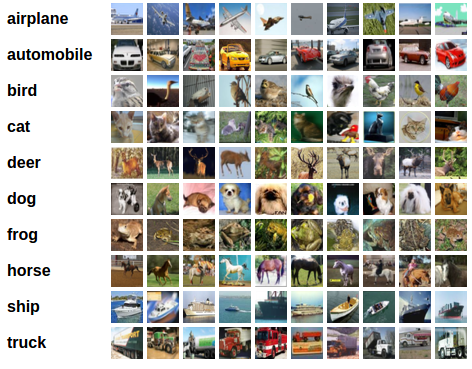

# Steps in Image Classification:-
## 1.Load and normalizing the CIFAR10 training and test datasets using torchvision
## 2.Define a Convolutional Neural Network
## 3.Define a loss function
## 4.Train the network on the training data
## 5.Test the network on the test data

# 1. Loading And Normalising Data


In [1]:
import torch
import torchvision
import torchvision.transforms as ts

## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform=ts.Compose(
    [ts.ToTensor(),
    ts.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

# Convert a PIL Image or numpy.ndarray to tensor.

Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

# Since its an image, we are sending 3 values of mean and 3 values of std, for each color channels of RGB.

# Normalize a tensor image with mean and standard deviation. 
Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. 
# input[channel] = (input[channel] - mean[channel]) / std[channel]



In [20]:
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,
                                     download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


# PARAMETERS USED ABOVE

## 1. root parameter is used to tell where we wnat to store the downloaded Dataset 

## 2. train if this  is set to True then in return we will get Training Datset and otherwise Testing dataset

## 3. download is used to tell wthether we want to download dataset or not. Default is False

## 4. transform is used to Normalization And Augmentaion of Data

# Plotting Some Images


In [35]:
%matplotlib
import matplotlib.pyplot as plt
import numpy as np


for i in range(10):
    print(classes[i])#various classes available in CIFAR10 Dataset


    
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
print(type(trainloader))

# Iterate over Batch Created Using DataLoader class above and Stored in trailoader
dataiter = iter(trainloader)

#To go to Next labelled Image in Batch
images, labels = dataiter.next()


# in Output for Labels we get tensor([8,5,8,7]) for images of ship,dog,ship,horse 
#It means ship is present at 9th Position in Our Labels List Printed Above and Dog at 6th,Horse at 8th
print(images.shape,labels)


# show images in Grid
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

for i in range(10):
    print(classes[i])

Using matplotlib backend: TkAgg
<class 'torch.utils.data.dataloader.DataLoader'>


torch.Size([4, 3, 32, 32]) tensor([8, 5, 8, 7])
 ship   dog  ship horse
plane
car
bird
cat
deer
dog
frog
horse
ship
truck


# Why we used np.transpose(npimg,(1,2,0)) ?
Because in when we load a Image in Pytorch by Default we Get Image Tensor of(C,H,W) Channels,Height,Width and to plot a Image using Matplolib.pyplot,imshow() we need Image in (H,W,C) format so we transpose the axis to (1,2,0) it means at First Will Come 
0th axis(i.e Height(1st) by Default in Pytorch) then 1st Axis (i.e Width(2nd) by Default in Pytorch) and Finally
2nd axis (i.e Channels(0th axis) By Defualt in Pytorch)

# Understanding a 3rd array In Numpy

https://stackoverflow.com/questions/22981845/3-dimensional-array-in-numpy



# 2. Define a Convolutional Neural Network
 
A Neural Networks That Takes 3 Chanels(R,G,B) as Input and Output 6 Activation Maps

In [53]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 6,kernel_size= (5,5))
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6,out_channels= 16, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features= 16 * 5 * 5, out_features= 120)
        self.fc2 = nn.Linear(in_features=120,out_features= 84)
        self.fc3 = nn.Linear(in_features=84,out_features= 10)#10 out_features because in CIFAR 10 has 10 Classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 3. Define a Loss function and optimizer

In [54]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network


In [55]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.271
[1,  4000] loss: 1.955
[1,  6000] loss: 1.721
[1,  8000] loss: 1.599
[1, 10000] loss: 1.520
[1, 12000] loss: 1.483
[2,  2000] loss: 1.385
[2,  4000] loss: 1.365
[2,  6000] loss: 1.336
[2,  8000] loss: 1.343
[2, 10000] loss: 1.286
[2, 12000] loss: 1.301
Finished Training


# 5. Test the network on the test data


In [56]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

<class 'torch.Tensor'>
(3, 36, 138)
(36, 138, 3)
GroundTruth:    cat  ship  ship plane


In [58]:
outputs = net(images)
print(outputs)

tensor([[-0.4672, -2.5935,  1.4267,  3.0919,  0.1376,  1.9819,  2.3032, -1.4673,
         -1.9415, -2.2187],
        [ 3.3593,  7.5976, -2.4274, -3.0181, -3.1492, -3.8883, -3.0764, -3.2031,
          4.5116,  5.5202],
        [ 0.7406,  2.8366, -0.6208, -0.4732, -1.0569, -1.3020, -0.8451, -1.7205,
          1.4786,  2.1155],
        [ 3.0836, -0.7787,  1.5598, -0.7594,  1.4738, -2.2851, -1.1669, -1.2778,
          1.1623, -0.7696]], grad_fn=<AddmmBackward>)


In [59]:
#The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class.
#So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


In [60]:
#For Complete Dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [61]:
# See what are the classes that performed well, and the classes that did not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 79 %
Accuracy of  bird : 43 %
Accuracy of   cat : 37 %
Accuracy of  deer : 31 %
Accuracy of   dog : 43 %
Accuracy of  frog : 80 %
Accuracy of horse : 54 %
Accuracy of  ship : 57 %
Accuracy of truck : 60 %
